# Begin Ising


In [1]:
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import itertools



def generateInput(beta,n, pz):
    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=pz, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal()) - sparse.diags(X.diagonal())
    result = result.toarray()
    result = np.array(result) #Frustrated result
    for i in range(n):
      for j in range(n):
        result[i,j] = beta * ((result[i,j]>0).astype('int') - (result[i,j]<0).astype('int'))
    return result


def s_all(n):
  return np.array(list(itertools.product([-1, 1], repeat=n)))
  
def Ising(n, J0, Jth, beta,c1=0.5,theta=0.001,sparse = True):

  th = np.random.normal(size=(n, 1)) * Jth #random theta
  if (not sparse):


  # mat=J0/n+J/np.sqrt(n)*np.random.normal(size=[n,n]) # make nxn matrix of standard normals
  # mat=mat-np.diag(np.diag(mat)) # set diagonal to 0
  # mat=np.tril(mat)+np.tril(mat).T #make the matrix symmetrical (copy the lower triangle to the top triangle)
  # C=(mat!=0) 
  # C=C.astype(int) #matrix set to 1 for non-zeroes

    J0 = 0
    J = beta
    w = ( J0 / n + J / np.sqrt(n)) * np.random.normal(size=[n,n])
    w = w - np.diag(np.diag(w))
    w = np.tril(w)+np.tril(w).T #
    c = (w!=0)
  else:
    # c1 =0.1     #TODO this is a parameter    (connectivity/sparseness for question 3)     
    th=theta *np.ones((n,1)) # TODO make sure this works parameter theta           
    k =c1*n
    w = generateInput(beta,n, c1)
    c = (w!=0)                 
              



  



  sa = s_all(n)         
  # print((np.dot(sa, th)).shape)   
  Ea = (0.5 * np.sum(np.multiply(sa, np.transpose((np.dot(w,np.transpose(sa))))),axis = 1)).reshape(2**n,1) + np.dot(sa, th)
  # Ea = 0.5 *sum(sa*(np.dot(w,sa.T)).T,2) + np.dot(sa,th);
  # print(Ea.shape)
  Ea = np.exp(Ea)
  Z = np.sum(Ea)
  p_ex= Ea /Z                
  m_ex= np.dot(np.transpose(sa), p_ex)      
  klad=np.multiply((np.dot(p_ex, np.ones((1,n)))), sa)
  chi_ex = np.dot(np.transpose(sa), klad) - np.dot(m_ex , np.transpose(m_ex))


  # error_bp = sqrt(1/n*np.power(sum(m_bp-m_ex),2))
  return [m_ex,th,w,chi_ex]

resultIsing=Ising(n = 20, J0 = 0, Jth = 0.1, beta = 0.1)


# print(resultIsing[0])
# print(resultIsing[1])
# print(resultIsing[2])

In [2]:
import numpy as np
from scipy.sparse import random

n=20

#mean field approximation
def mf_approx(w,theta,smoothing=0.5):

  #initialize
  m=np.random.rand(n)
  dm=1

  #iterate
  for i in range(100000):
    temp=np.dot(w,m)
    temp2=temp+theta
    mprime=np.tanh(temp2)
    newm=smoothing*m+(1-smoothing)*mprime
    dm=np.max(np.abs(newm-m))
    m=newm
    if dm<10**(-13):
      break;
  m_mf=m
  return [m_mf,i]


# #mean field approximation 2
# def mf_approx2(w,theta,smoothing=0.5):
#   #initialize
#   m=np.random.rand(n,n)
#   dm=1
#   theta2=theta+theta.T

#   #iterate
#   for i in range(100000):
#     temp=np.dot(w,m)
#     temp2=temp+theta2
#     mprime=np.tanh(temp2)
#     newm=smoothing*m+(1-smoothing)*mprime
#     dm=np.max(np.abs(newm-m))
#     m=newm
#     if dm<10**(-13):
#       break;
#   m_mf=m
#   return [m_mf,i]
# print("test")





theta=resultIsing[1].T[0]
smoothing=0.5
w=resultIsing[2]
m_mf=mf_approx(w,theta,smoothing)[0]


#belief propagation
#TODO fix
def bp_approx(w,theta):
  #initialize
  da=1
  a=np.random.rand(n,n)

  #start loop
  for iter in range(1000):
    if(da<10**(-13)):
      break
    aold=a
    mxplus=[]
    mxminus=[]
    for j in range(n):
      onesarray=np.ones(n)
      onesarray[j]=0 #set the j'th element to 0 so that we can sum over all indices except j


      sumterm=np.dot(a,onesarray.T) #the 3rd term
      # sumterm=np.dot(onesarray,a) #the 3rd term

      thetaterm=theta #the second term
      wxterm=w.T[j].T
      # # try row instead of collumn
      # wxterm=w[j]

      termplus=sumterm+thetaterm+wxterm
      termminus=sumterm+thetaterm-wxterm
      # print("test")
      # print(termplus)
      # print(sumterm)
      # print(wxterm)
      # print(thetaterm)
      coshplus=2*np.cosh(termplus)
      coshminus=2*np.cosh(termminus)
      mxplus.append(coshplus)
      mxminus.append(coshminus)


    mxplus=np.array(mxplus)
    mxminus=np.array(mxminus)
    a= mxplus/mxminus #devide the matrices
    a=np.log(a)/2 #take the log divided by 2
    da=np.max(np.abs(a-aold))
  


  #cmpute the resulting m
  onesarray=np.ones(n)
  sumterm=np.dot(onesarray,a) # compute the sommation over j
  #test sum over other axis
  sumterm=np.dot(a,onesarray.T)
  res=sumterm + theta #add theta
  m_bp=np.tanh(res)


  return [m_bp,iter,a]

  # temp3=temp+theta+np.dot(w,onesarray)#dot product with x=1 ? so ones?
  # temp4=temp+theta-np.dot(w,onesarray)#dot product with x=1 ? so ones?

m_bp=bp_approx(w,theta)[0]
m_ex=resultIsing[0].T

def rmse(ex,mf):
  return np.sqrt(((ex - mf) ** 2).mean())

  
def correltions_bp(a,m,n):
  result=[]
  for i in range(n):
    for j in range(n):
      result.append(coorelation_bp(i,j,a,m))

  return result
def coorelation_bp(i, j, a, m):
  Z = 0
  for xi in [-1,1]:
    for xj in [-1,1]:
      Z += bij(i,j,xi,xj,a)
  
  b = 0
  for xi in [-1,1]:
    for xj in [-1,1]:
      b += xi*xj*bij(i,j,xi,xj,a)
  
  return (b/Z) - m[i] * m[j]
  
  
def bij(i, j, x_i, x_j, a):
  sum1 = 0
  for k in range(n):
    if k == j:
      continue
    else: 
      sum1 += a[k][i] * x_i
  sum2 = 0
  for k in range(n):
    if k == i:
      continue
    else: 
      sum2 += a[k][j] * x_j
  return np.exp(w[i][j]*x_i*x_j+ theta[i]*x_i + theta[j]*x_j + sum1 + sum2)


def xiLR(m,w,n):
  A=np.ones([n,n])
  for i in range(n):
    for j in range(n):
      if(i==j):
        A[i][j]=1/(1-m[i]**2)-w[i][j]
      else: #delta=1 ? maybe something else
        A[i][j]=-w[i][j]

  Ainv=np.linalg.inv(A)
  return Ainv


def xierror(res1,res2):
  re1=np.array(res1).flatten()
  re2=np.array(res2).flatten()
  return rmse(re1,re2)


# print(m_bp)
# print(m_mf)
# print(m_ex)
# print(rmse(m_ex,m_mf))
# print(rmse(m_ex,m_bp))





In [3]:
m_mf=mf_approx(w,theta,smoothing)[0]
m_bp=bp_approx(w,theta)[0]
print(m_mf)
print(m_bp)

[0.00152028 0.00098765 0.0008928  0.00051298 0.0012798  0.00082574
 0.00095388 0.00109332 0.00081435 0.00105439 0.00101423 0.00077188
 0.00098348 0.00107474 0.00128685 0.00066707 0.00105408 0.00122044
 0.00123963 0.00090029]
[0.0013257  0.00092573 0.00085755 0.00051627 0.00115372 0.00076434
 0.00087617 0.0010121  0.00076992 0.00096725 0.00090423 0.00072608
 0.00087743 0.00097465 0.00116475 0.00064897 0.0009186  0.00111543
 0.00110989 0.00080137]


In [4]:
#data for for beta values

#tested beta values
testperbeta=1
betastart=0
betaend=2
betaiter=0.1

#constant smoothing
smoothing=0.5

betai=betaiter



mferror=[]
bperror=[]

mfmean=[]
mfsd=[]

mfiters=[]
bpiters=[]

bpmean=[]
bpsd=[]

#TODO note for not fully connected model consider only connected correlations
bpxierrors=[]
lrxierrors=[]


#betas for plotting
betas=[]
randomerror=[] #random guess



while betai<=betaend:
  betas.append(betai)
  print(betai)

  mferror=[]
  bperror=[]
  mfiter=[]
  bpiter=[]

  #TODO note for not fully connected model consider only connected correlations
  bpxierror=[]
  lrxierror=[]

  for i in range(testperbeta):
    resultIsing=Ising(n = 20, J0 = 0, Jth = betai, beta = betai,sparse=False)
    theta=resultIsing[1].T[0]
    m_ex=resultIsing[0].T
    w=resultIsing[2]
    xi_ex=resultIsing[3]

    [m_mf,mfresiter]=mf_approx(w,theta,smoothing)
    [m_bp,bpresiter,a_bp]=bp_approx(w,theta)
    m_random=np.random.uniform(low=-1.0, high=1.0, size=[n]) #random guess
    

    mferror.append(rmse(m_ex,m_mf))
    bperror.append(rmse(m_ex,m_bp))
    randomerror.append(rmse(m_ex,m_random)) # random guess

    bpiter.append(bpresiter)
    mfiter.append(mfresiter)

    #xi errors (note TODO if not fully connected consider connectivity)
    bpxierror.append(xierror(xi_ex,correltions_bp(a_bp,m_bp,n)))
    lrxierror.append(xierror(xi_ex,xiLR(m_mf,w,n)))


  mfiters.append(np.mean(mfiter))
  bpiters.append(np.mean(bpiter))

  mfmean.append(np.mean(mferror))
  mfsd.append(np.std(mferror))
  bpmean.append(np.mean(bperror))
  bpsd.append(np.std(bperror))
  
  #xi errors (note TODO if not fully connected consider connectivity)
  bpxierrors.append(np.mean(bpxierror))
  lrxierrors.append(np.mean(lrxierror))


  betai+=betaiter

print(mferror)
print(bperror)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
[0.3206881134909552]
[0.05170021187168582]


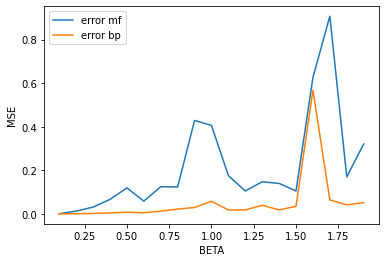

[129]
[155]


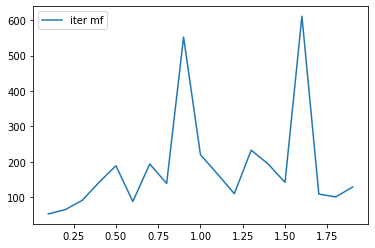

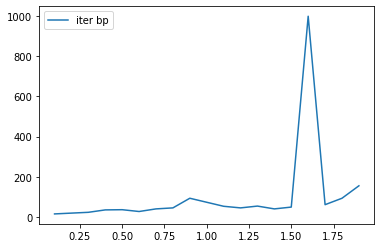

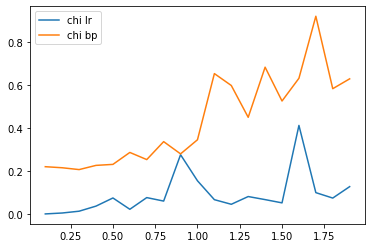

0.3206881134909552
0.0
[0.001018467185592816, 0.012976614146927922, 0.0313325255122175, 0.06670622692938732, 0.11937381159560637, 0.05875892407214799, 0.1245328895037903, 0.12402638116880962, 0.4289541044604111, 0.4058622747463401, 0.17573167818470975, 0.10515354112684504, 0.14743046624334852, 0.13999060109791953, 0.10519718903794466, 0.6259214771888137, 0.9067934243491225, 0.17010640562288382, 0.3206881134909552]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [5]:

import matplotlib.pyplot as plt


#plotting data values

plt.plot(betas,mfmean, label="error mf")
plt.plot(betas,bpmean, label="error bp")
# plt.plot(betas,randomerror, label="error random")
plt.legend()
plt.xlabel("BETA")
plt.ylabel("MSE")
plt.show()

print(mfiter)
print(bpiter)
plt.plot(betas,mfiters, label="iter mf")
plt.legend()
plt.show()
plt.plot(betas,bpiters, label="iter bp")
plt.legend()
plt.show()

plt.plot(betas,lrxierrors, label="chi lr")
plt.plot(betas,bpxierrors, label="chi bp")

plt.legend()
plt.show()

print(np.mean(mferror))
print(np.std(mferror))
print(mfmean)
print(mfsd)



In [19]:
#plot the sparse results

import matplotlib.pyplot as plt
import seaborn as sns


def plot_heatmap(crange, brange, mferrormatrix, bperrormatrix, theta):
  fig = plt.figure()
  fig2=plt.figure()
  ax1 = fig.add_subplot(111)
  ax2 = fig2.add_subplot(111)


  # rounding
  crange=np.around(crange,decimals=3)
  brange=np.around(brange,decimals=3)

  a=sns.heatmap(mferrormatrix,ax=ax1,xticklabels=brange,yticklabels=crange,label="adf")
  a.set_xlabel("beta")
  a.set_ylabel("connectivity")
  a.set_title("MF approximation MSE error, theta:{}".format(theta))

  b=sns.heatmap(bperrormatrix,ax=ax2,xticklabels=brange,yticklabels=crange)
  b.set_xlabel("beta")
  b.set_ylabel("connectivity")
  b.set_title("BP approximation MSE error, theta:{}".format(theta))


[0.2 0.4 0.6 0.8 1. ]
0
0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1
0
2
0
3
0
4
1
0
1
1
1
2
1
3
1
4
2
0
2
1
2
2
2
3
2
4
3
0
3
1
3
2
3
3
3
4
4
0
4
1
4
2
4
3
4
4
[[2.41693623e-05 5.62846962e-05 1.00385337e-04 1.66558691e-04
  1.72555246e-04]
 [1.63320277e-04 3.56047423e-01 8.51650124e-02 5.60720534e-01
  7.86057347e-01]
 [6.18298096e-02 8.07423619e-01 7.65700658e-01 9.05521373e-01
  8.03430142e-01]
 [7.49244452e-01 9.14465015e-01 7.43512188e-01 8.25071435e-01
  9.33528327e-01]
 [9.47488098e-01 9.19476599e-01 8.45684571e-01 8.62114555e-01
  9.69852324e-01]]
[0.9698523244631835]
[0.2 0.4 0.6 0.8 1. ]
0
0
0
1
0
2
0
3
0
4
1
0
1
1
1
2
1
3
1
4
2
0
2
1
2
2
2
3
2
4
3
0
3
1
3
2
3
3
3
4
4
0
4
1
4
2
4
3
4
4
[[1.27085286e-04 3.58098243e-04 1.32831420e-03 1.65049651e-03
  4.69481528e-03]
 [6.64390280e-04 3.44234525e-01 1.89660109e-01 2.45993159e-01
  7.55132452e-01]
 [3.54105555e-01 7.33180730e-01 8.31594928e-01 8.28664392e-01
  8.84031088e-01]
 [5.78377304e-01 9.05079035e-01 9.56542873e-01 7.03154759e-01
  9.20165638e-01]
 [6.54748970e-01 7.82870717e-01 9.492622

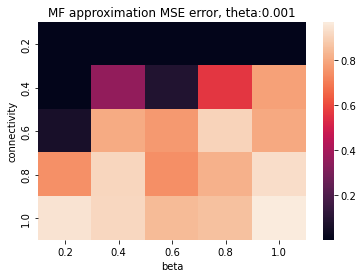

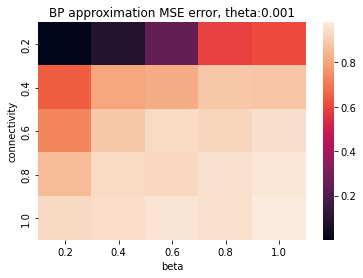

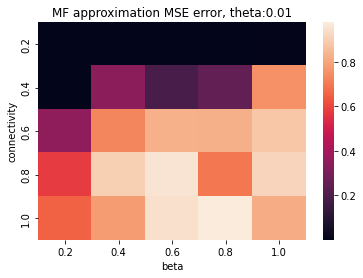

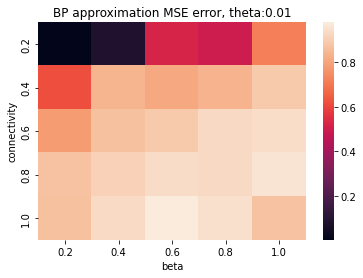

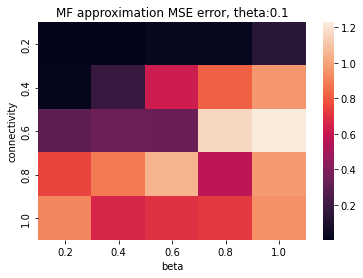

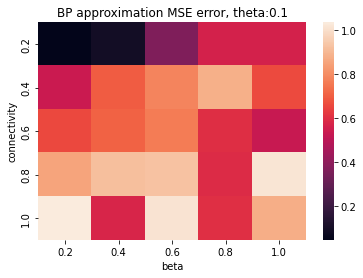

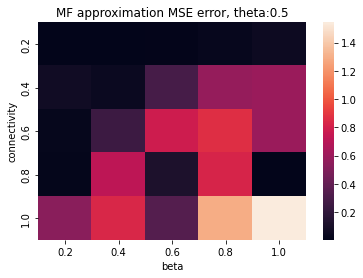

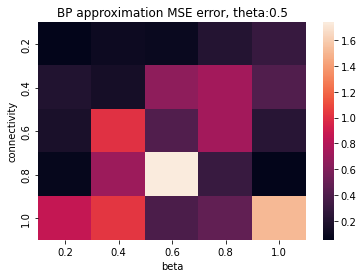

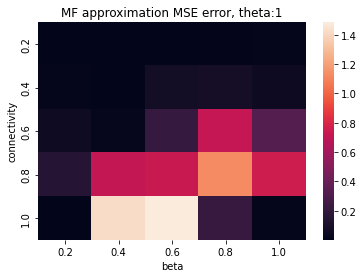

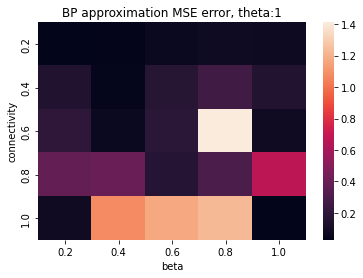

In [20]:
#tested sparese model for connectivitity values

theta_values = [0.001,0.01,0.1,0.5,1]
for theta_i in theta_values:
  testperbeta=1

  betastart=0
  betaend=1
  betaiter=0.2

  cstart=0
  cend=1
  citer=0.2

  crange=np.array(range(int(((cend-cstart)/citer))))*citer+citer
  brange=np.array(range(int(((betaend-betastart)/betaiter))))*betaiter+betaiter
  print(crange)

  #constant n
  n=20
  #constant theta ?
  # thetaconstant=0.1


  #constant smoothing
  smoothing=0.5

  betai=betaiter



  mferror=[]
  bperror=[]

  mfmean=[]
  mfsd=[]

  mfiters=[]
  bpiters=[]

  bpmean=[]
  bpsd=[]

  #TODO note for not fully connected model consider only connected correlations
  bpxierrors=[]
  lrxierrors=[]


  #betas for plotting
  betas=[]
  randomerror=[] #random guess

  mferrormatrix=np.zeros((crange.size,brange.size))
  bperrormatrix=np.zeros((crange.size,brange.size))
  # print(mferrormatrix)


  k=-1
  while betai<=betaend:
    k+=1
    j=-1
    for c in crange:
      j+=1

      betas.append(betai)
      print(k)
      print(j)

      mferror=[]
      bperror=[]
      mfiter=[]
      bpiter=[]


      for i in range(testperbeta):
        resultIsing=Ising(n = 20, J0 = 0, Jth = betai, beta = betai,c1=c,theta=theta_i)
        theta=resultIsing[1].T[0]
        m_ex=resultIsing[0].T
        w=resultIsing[2]
        xi_ex=resultIsing[3]

        [m_mf,mfresiter]=mf_approx(w,theta,smoothing)
        [m_bp,bpresiter,a_bp]=bp_approx(w,theta)
        m_random=np.random.uniform(low=-1.0, high=1.0, size=[n]) #random guess
        

        mferror.append(rmse(m_ex,m_mf))
        bperror.append(rmse(m_ex,m_bp))
        randomerror.append(rmse(m_ex,m_random)) # random guess


      mfiters.append(np.mean(mfiter))
      bpiters.append(np.mean(bpiter))

      mfmean.append(np.mean(mferror))
      mfsd.append(np.std(mferror))
      bpmean.append(np.mean(bperror))
      bpsd.append(np.std(bperror))
      
      #matrix filled in
      mferrormatrix[k][j]=np.mean(bperror)
      bperrormatrix[k][j]=np.mean(mferror)



    betai+=betaiter

  plot_heatmap(crange, brange, mferrormatrix, bperrormatrix, theta_i)
  print(mferrormatrix)
  print(bperror)


In [ ]:
# n=3
# Jth=0.1; 


# #full weight matrix
# J0= 0                    
# J=0.5
# mat=J0/n+J/np.sqrt(n)*np.random.normal(size=[n,n]) # make nxn matrix of standard normals
# mat=mat-np.diag(np.diag(mat)) # set diagonal to 0
# mat=np.tril(mat)+np.tril(mat).T #make the matrix symmetrical (copy the lower triangle to the top triangle)
# C=(mat!=0) 
# C=C.astype(int) #matrix set to 1 for non-zeroes


# #sparse matrix
# c1=0.5;                          # connectivity is the approximate fraction of non-zero links in the random graph on n spins
# k=c1*n;
# beta=0.1;

# w=random(n,n,density=c1)  #sparse matrix
# sparsem=(w.A!=0).astype(int) #sparse matrix of ones and zeroes, approx c1 ones
# mat=np.random.normal(size=[n,n]) #random normal matrix
# mat=mat-np.diag(np.diag(mat)) # set diagonal to 0

# mat=mat*sparsem
# mat=np.tril(mat)+np.tril(mat).T #make the matrix symmetrical (copy the lower triangle to the top triangle)



# C=(mat!=0) 

# mat=((mat>0).astype(int)-(mat<0).astype(int))*beta #set values to +- beta





# #value for th (some random normal vector)
# th=np.random.normal(size=[n,1])*Jth



# for i in range((2**(N))):
#   a=np.binary_repr(i).zfill(N) #create binary number
#   b=[int(x) for x in str(a)] #interpret binary number as array
#   b=np.reshape(b,[n,n]) #reshape array to matrix
#   configs.append(b)


# binary_repr_vec = np.vectorize(np.binary_repr)
# c=binary_repr_vec(range(2**N),width=N)
# print(c)

# sa=np.array(configs)*2-1
# print(np.array(configs)*2-1)
# Ea = 0.5 *sum(sa*(np.dot(w,sa.T)).T,2) + np.dot(sa,th); # array of the energies of all 2^n configurations
# Ea=np.exp(Ea); 
# Z=sum(Ea); 
# p_ex=Ea /Z ;                # probabilities of all 2^n configurations


#!!!!!!! look at transpose definition (which axes get transposed (possible solution is to take diagonal like before))
# m_ex=np.dot(sa.transpose([1,0,2]) ,p_ex);             # exact mean values of n spins

# klad=(np.dot(p_ex,np.ones([n,1])))*sa;

#!!!!!!!!
# print(klad.shape)
# print(sa.shape)
# print(np.dot(sa.transpose([2,0,1]),klad).shape)


# chi_ex=np.dot(sa.transpose([1,0,2]),klad)-np.dot(m_ex.transpose([1,0,3,2]),m_ex); # exact connected correlations


## Mean field approximation
# theta=np.random.rand(n) #random theta
# theta=th.T[0] # th is theta
# w=mat

In [ ]:
print(s_all(20).shape)
print(s_all(20)[0])
all=s_all(20)


(1048576, 20)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
